In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from math import log2, floor, ceil
from statistics import mean, median

In [11]:
def load_file(filename):
    a = np.loadtxt(filename, dtype='str', comments='#')
    rsp = [round(float(x),6) for x in  a[:,0]]
    latencies = a[:,1]
    times = a[:,2]
    processors = a[:,3]
    work = a[:,4]
    i_steals = a[:,16]
    e_steals = a[:,17]
    return rsp, latencies, times, processors, work#, i_steals, i_steals

directory = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_50p/"
directory_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_70p/"
directory_80p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_80p/"
directory_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_90p/"

#/home/khatiri/these/projet/ws-simulator/Simulation/proba/"

In [12]:
def compute_average(values, latence):
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            run_number[float(rsp[i])] += 1
            average[float(rsp[i])] += int(values[i])
            
    for cle in average:
        average[cle] /= run_number[cle]
    return average

def compute_overhead_for_latence(data, latence):
    rsp, latencies, times, processors, work = data
    all_average = defaultdict(list)
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))
    for cle in sorted(all_average):
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return all_average, average, min(average.keys(), key=lambda x : average[x])


def compute_overhead(data, latence, variable):
    rsp, latencies, times, processors, work = data
    average = defaultdict(int)
    run_number = defaultdict(int)
    average = 0
    run_number = 0
    
    for i in range(len(rsp)):
        if float(rsp[i]) == variable and float(latencies[i]) == latence:
            run_number += 1
            average += float(int(times[i]) - int(work[i])/int(processors[i]))
            
    return average/run_number

In [13]:
def plot_for_best(filename, cond_base_line=False):
    best = dict()
    base_line = dict()
    data = load_file(filename)
    latencies = data[1]
    for latence in sorted(set(latencies), key=lambda x: int(x)):
        if int(latence) >= 64:
            all_average, avg_overhead, minimum  = compute_overhead_for_latence(data, int(latence))
            best_avg_overhead = compute_overhead(data, int(latence), minimum)
            best[latence] = best_avg_overhead
            if cond_base_line:
                base_line[latence] = compute_overhead(data, int(latence), 0.5)
                #print(latence, minimum)
    
    return best, base_line

In [14]:
def latence_for_best_param(filename):
    data = load_file(filename)
    latencies = data[1]
    best = dict()

    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, overhead, minimum = compute_overhead_for_latence(data, int(latence))
        #plt.subplot(223)
        plt.plot(overhead.keys(), overhead.values())
        best[latence] = minimum
    return best

In [15]:
def best_overhead_dict(directory):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16, 32, 64):
            filename = directory + "vss_static_" + str(p) + "_" + str(w)
            best, _ = plot_for_best(filename)
            for latence in best.keys():
                best_value_w[(p, int(latence))][w]=best[latence]
                best_value_p[(w, int(latence))][p]=best[latence]
                best_value_l[(w, p)][int(latence)]=best[latence]

    return best_value_w, best_value_p, best_value_l

In [16]:
def best_value_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32,64):
            filename = directory + "vss_static_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (128,256,512,1024):
                _, overhead, minimum = compute_overhead_for_latence(data, latence)
                
                overhead_min = overhead[minimum]
                interval_max = overhead[minimum]  + 2*latence/p #+ overhead[minimum]*seuil/100

                #print(minimum, overhead[minimum], interval_max)
                
                
                overhead_plage = list(filter(lambda x : overhead_min <= overhead[x] <= interval_max, overhead))
                
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= overhead_plage
                best_value_p[(w, int(latence))][p]= overhead_plage
                best_value_l[(w, p)][int(latence)]= overhead_plage

    return best_value_w, best_value_p, best_value_l



## overhead en fonction de maximum internal steal attempts
$\lambda={128,256,512}$, $p=16,32,64$, $W=10^7,5.10^7,10^8,5.10^8$

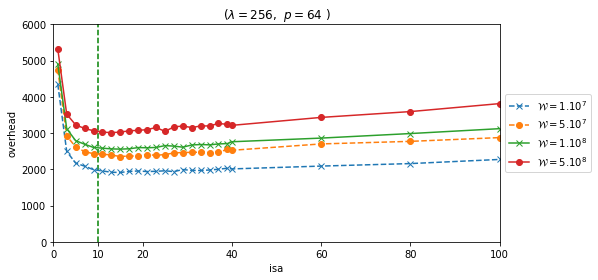

In [21]:
fig = plt.figure()
fig.set_size_inches(8, 4, forward=True)

#plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 0

#limits
l=256
p=64
limy, limx = 0, 6000
plt.xlim(0, 100)
plt.ylim(limy, limx)
plt.xlabel("isa")
plt.ylabel("overhead")
plt.title("($\lambda = "+str(l)+"$,  $p="+str(p)+"$ )")

plt.xticks([0,10,20,40,60,80,100])

plt.axvline(x=10,linestyle='--', color='g')

for w1, w2, s in sorted({(10000000,"1.$10^7$", "x--"),(50000000,"5.$10^7$", "o--"), (100000000,"1.$10^8$", "x-"), (500000000,"5.$10^8$", "o-")}):
    data = load_file(directory + "vss_static_"+str(p)+"_"+str(w1))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    plt.plot(overhead.keys(), overhead.values(), s, label="$\mathcal{W} =$"+w2)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('../../../../../presentation/soutnance_slides/figs/overhead_according_static_max.pdf',bbox_inches='tight')


64 10000000 16 5.0
64 50000000 16 5.0
64 100000000 16 5.0
64 500000000 16 5.0
64 10000000 32 7.0
64 50000000 32 7.0
64 100000000 32 5.0
64 500000000 32 5.0
64 10000000 64 7.0
64 50000000 64 11.0
64 100000000 64 9.0
64 500000000 64 7.0
128 10000000 16 5.0
128 50000000 16 5.0
128 100000000 16 5.0
128 500000000 16 7.0
128 10000000 32 9.0
128 50000000 32 9.0
128 100000000 32 7.0
128 500000000 32 7.0
128 10000000 64 11.0
128 50000000 64 9.0
128 100000000 64 9.0
128 500000000 64 9.0
256 10000000 16 5.0
256 50000000 16 5.0
256 100000000 16 5.0
256 500000000 16 7.0
256 10000000 32 11.0
256 50000000 32 7.0
256 100000000 32 9.0
256 500000000 32 13.0
256 10000000 64 15.0
256 50000000 64 15.0
256 100000000 64 15.0
256 500000000 64 13.0
512 10000000 16 5.0
512 50000000 16 5.0
512 100000000 16 13.0
512 500000000 16 5.0
512 10000000 32 19.0
512 50000000 32 11.0
512 100000000 32 17.0
512 500000000 32 11.0
512 10000000 64 25.0
512 50000000 64 13.0
512 100000000 64 15.0
512 500000000 64 19.0


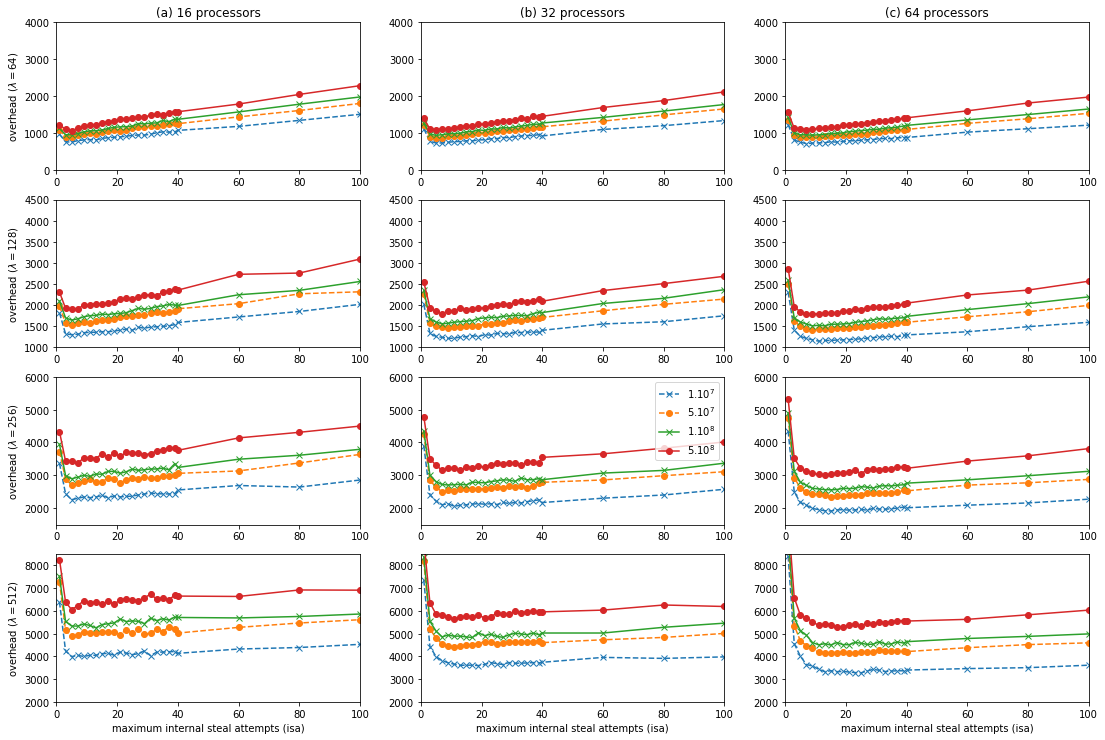

In [10]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

#plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 0
for (l, limy, limx) in sorted({(64,0,4000),(128, 1000, 4500),(256,1500, 6000),(512,2000, 8500)}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(4, 3, position)
        
        #labels
        if l == 512:
            plt.xlabel("maximum internal steal attempts (isa)")
        if l == 64:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0, 100)
        plt.ylim(limy, limx)

        #plots
        for w1, w2, s in sorted({(10000000,"1.$10^7$", "x--"),(50000000,"5.$10^7$", "o--"), (100000000,"1.$10^8$", "x-"), (500000000,"5.$10^8$", "o-")}):
            data = load_file(directory + "vss_static_"+str(p)+"_"+str(w1))
            #plt.title("l="+str(l)+" p="+str(p)+" w="+str(w1))
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            print(l, w1, p, minimum)
            plt.plot(overhead.keys(), overhead.values(), s, label=w2)
        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_l.pdf',bbox_inches='tight')


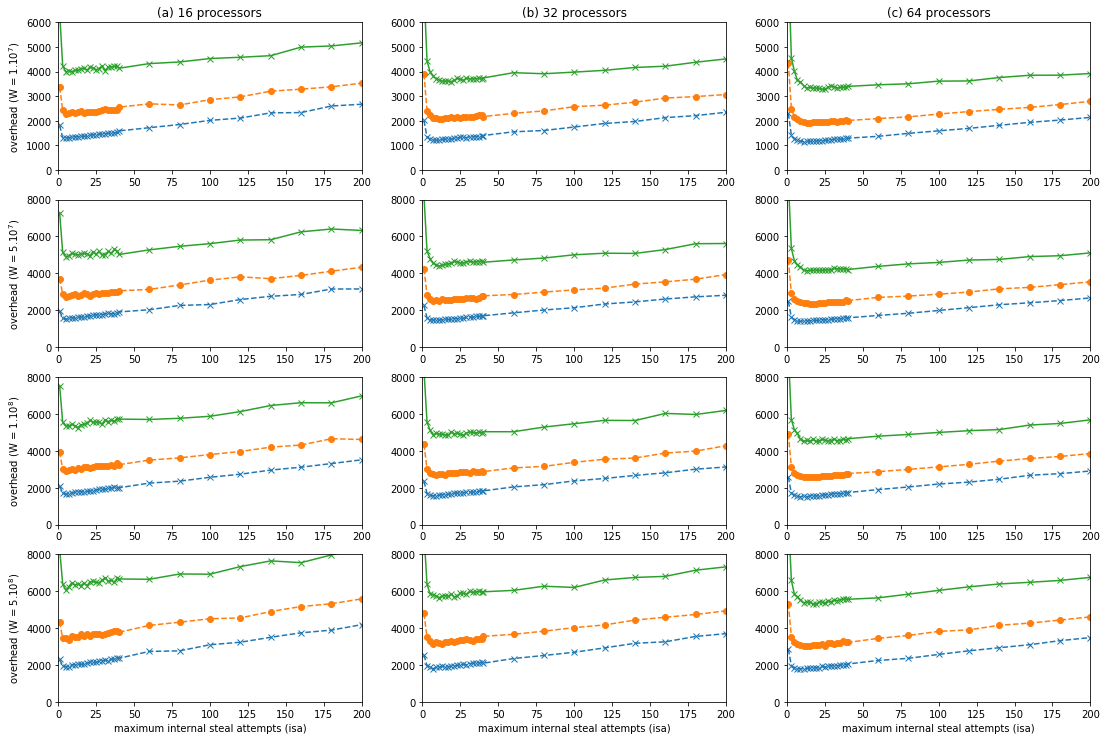

In [10]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

position = 0
for w1, w2 in sorted({(10000000,"1.$10^7$"),(50000000,"5.$10^7$"), (100000000,"1.$10^8$"), (500000000,"5.$10^8$")}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        
        
    
        #position
        position += 1
        plt.subplot(4, 3, position)
        plt.ylim(0,8000)

        #plots
        data = load_file(directory + "vss_static_"+str(p)+"_"+str(w1))
        
        for l,s in sorted({(128, "x--"), (256, "o--"), (512, "x-")}):
            if w1 == 10000000:
                plt.title(c+" "+str(p)+" processors")
                plt.ylim(0,6000)

            if w1 == 500000000:
                plt.xlabel("maximum internal steal attempts (isa)")
            if p == 16:
                plt.ylabel("overhead (W = "+w2+")")
            
            plt.xlim(0, 200)
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), s, label=w2)
        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
        plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_w.pdf',bbox_inches='tight')

#en fonction $W$


In [31]:
def boxdata(p, w, l, rspmin, rspmax):
    data = load_file(directory + "vss_static_{}_{}".format(p,w))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    #print(all_average)
    return [all_average[x] for x in all_average.keys() if rspmin <= x and x <= rspmax], \
[round(x,6) for x in all_average.keys() if rspmin <= x and x <= rspmax]


In [32]:
best_w, best_p, best_l = best_value_dict(directory, 2)


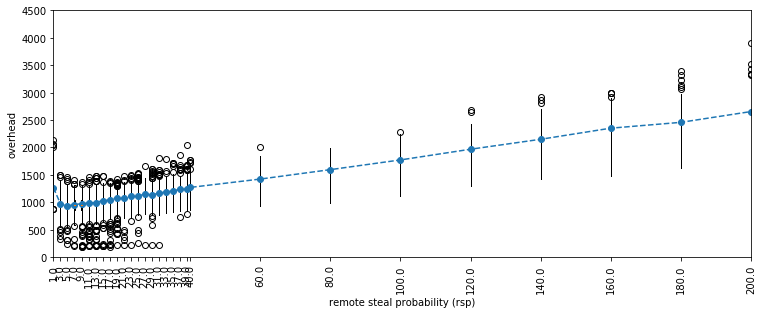

In [47]:
"""
fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)
list_avrg, list_keys = boxdata(32, 100000000, 128, 0, 200)
maxim = max(best_w[(32,128)][100000000])
#plt.subplot(111)

plt.xlabel("maximum internal steal attempts (isa)")
plt.ylabel("overhead")

data = load_file(directory + "vss_static_32_100000000")

plt.ylim(0, 6000)
plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 256")
"""




fig = plt.figure()
fig.set_size_inches(12.5, 10, forward=True)

#plt.subplot(2, 1, 1)
#list_avrg, list_keys = boxdata(32, 100000000, 64, 0, 200)
#plt.title("latence = 64")
##plt.xlabel("remote steal probability (rsp)")
#plt.ylabel("overhead")
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

#data = load_file(directory + "vss_static_32_100000000")

#plt.ylim(0, 3500)
##plt.xticks(rotation=90)
#w = [0.1]*len(list_keys)
#keys_positions = [x*100 for x in list_keys]
#plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
#_, overhead, minimum = compute_overhead_for_latence(data, 64)
#plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 64")

plt.subplot(2, 1, 2)
list_avrg, list_keys = boxdata(64, 100000000, 64, 0, 200)
plt.xlabel("remote steal probability (rsp)")
plt.ylabel("overhead")

data = load_file(directory + "vss_static_32_100000000")

plt.ylim(0, 4500)
plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 512")
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/box_overhead_according_static_max_100000000_32.pdf',bbox_inches='tight')


il faut ajouter un diagrame pour montrer la difference entre le pire et le meilleur

#en fonction $Proc\_number$


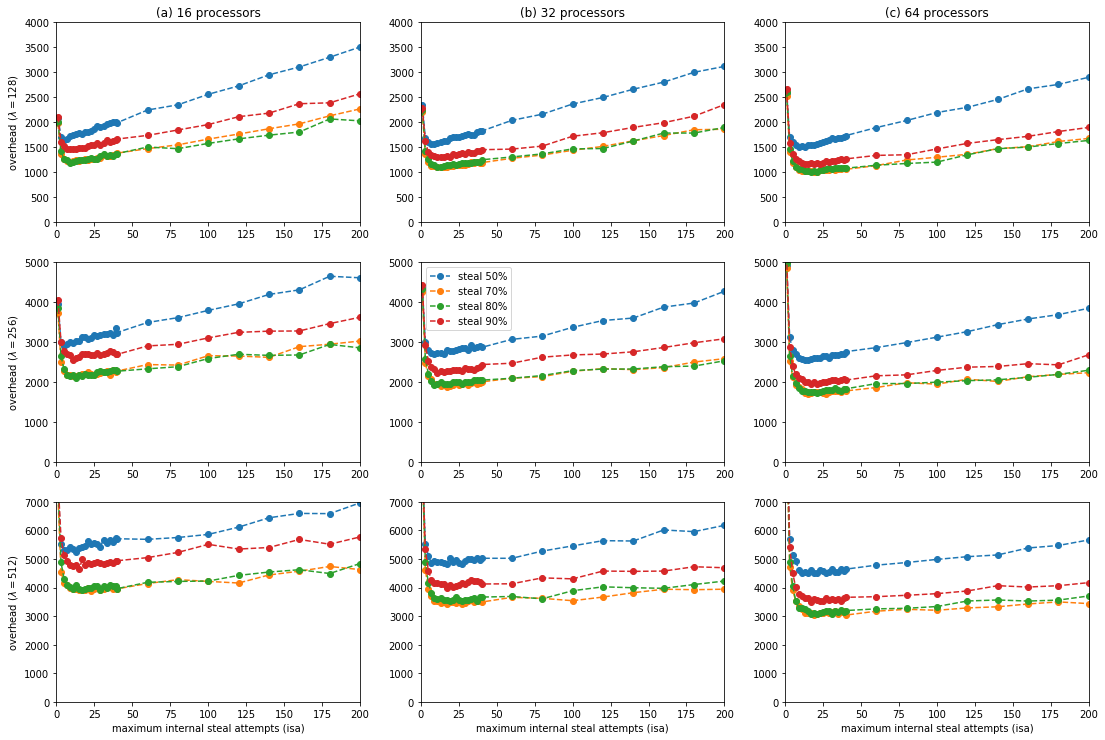

In [14]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 330
for (l,lim) in sorted({(128,4000),(256,5000),(512,7000)}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(position)
        
        #labels
        if l == 512:
            plt.xlabel("maximum internal steal attempts (isa)")
        if l == 128:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0, 200)
        plt.ylim(0, lim)
        
        #plots
        for w1, w2, s in {(100000000,"1.$10^8$", "x--")}:
            filename = directory  + "vss_static_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "o--", label="steal 50%")

            filename = directory_70p + "vss_static_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "o--", label="steal 70%")

            filename = directory_80p + "vss_static_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "o--", label="steal 80%")

            filename = directory_90p + "vss_static_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "o--", label="steal 90%")
                    
                                        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_steal_amount_overhead_according_isa.pdf',bbox_inches='tight')


## amount of work steal (50%, 70%, 80%, 90%)


# comparaison entre les strategies

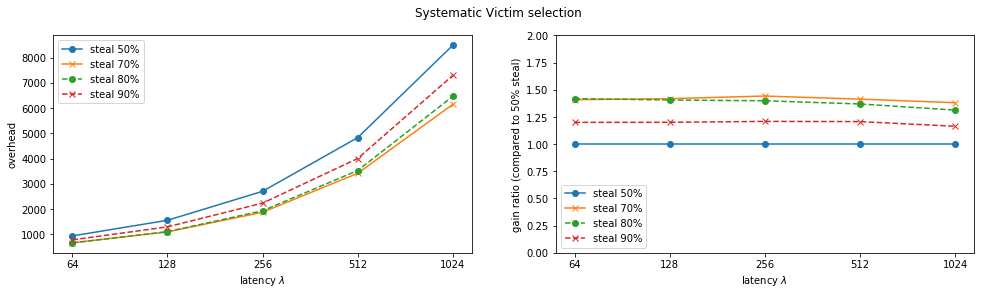

In [32]:
fig = plt.figure()
fig.set_size_inches(16.5, 4, forward=True)
plt.suptitle("Systematic Victim selection")

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
plt.subplot(121)

filename = directory  + "vss_static_32_100000000"
best_static_50, _ = plot_for_best(filename)


filename = directory_90p + "vss_static_32_100000000"
best_static_90, _ = plot_for_best(filename)

filename = directory_80p + "vss_static_32_100000000"
best_static_80, _ = plot_for_best(filename)

filename = directory_70p + "vss_static_32_100000000"
best_static_70, _ = plot_for_best(filename)

#filename = directory_r + "vss_proba_dynamic_40p_32_100000000"
#best_proba_dynamic_60, _ = plot_for_best(filename)
plt.xlabel("latency $\lambda$")
plt.ylabel("overhead")
#plt.plot(base_line.keys(), base_line.values(), 'o-', label="best_proba")
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="steal 50%")
plt.plot(best_static_70.keys(), best_static_70.values(), 'x-', label="steal 70%")
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="steal 80%")
plt.plot(best_static_90.keys(), best_static_90.values(), 'x--', label="steal 90%")

plt.legend()



plt.subplot(122)
plt.ylabel("gain ratio (compared to 50% steal)")
plt.xlabel("latency $\lambda$")

#fig = plt.figure()
#fig.set_size_inches(8.5, 4, forward=True)
plt.ylim(0,2)
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_50.values(), best_static_50.values())], 'o-', label="steal 50%")
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_70.values(), best_static_50.values())], 'x-', label="steal 70%")
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_80.values(), best_static_50.values())], 'o--', label="steal 80%")
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_90.values(), best_static_50.values())], 'x--', label="steal 90%")
plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_steal_amount_for_best_overhead_according_isa_l.pdf',bbox_inches='tight')


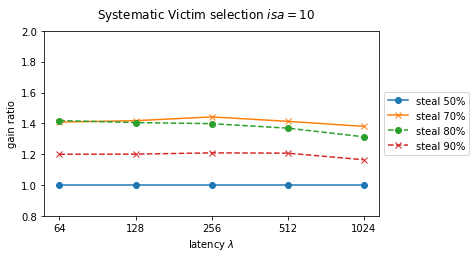

In [28]:
fig = plt.figure()
fig.set_size_inches(6, 3.4, forward=True)
plt.suptitle("Systematic Victim selection $isa=10$")

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory  + "vss_static_32_100000000"
best_static_50, _ = plot_for_best(filename)

filename = directory_90p + "vss_static_32_100000000"
best_static_90, _ = plot_for_best(filename)

filename = directory_80p + "vss_static_32_100000000"
best_static_80, _ = plot_for_best(filename)

filename = directory_70p + "vss_static_32_100000000"
best_static_70, _ = plot_for_best(filename)



plt.ylabel("gain ratio")
plt.xlabel("latency $\lambda$")
plt.ylim(0.8,2)

#fig = plt.figure()
#fig.set_size_inches(8.5, 4, forward=True)
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_50.values(), best_static_50.values())], 'o-', label="steal 50%")
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_70.values(), best_static_50.values())], 'x-', label="steal 70%")
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_80.values(), best_static_50.values())], 'o--', label="steal 80%")
plt.plot(best_static_50.keys(), [bl/b for (b, bl) in zip(best_static_90.values(), best_static_50.values())], 'x--', label="steal 90%")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend()

plt.savefig('../../../../../presentation/soutnance_slides/figs/comp_steal_amount_for_best_overhead_according_isa_l.pdf',bbox_inches='tight')


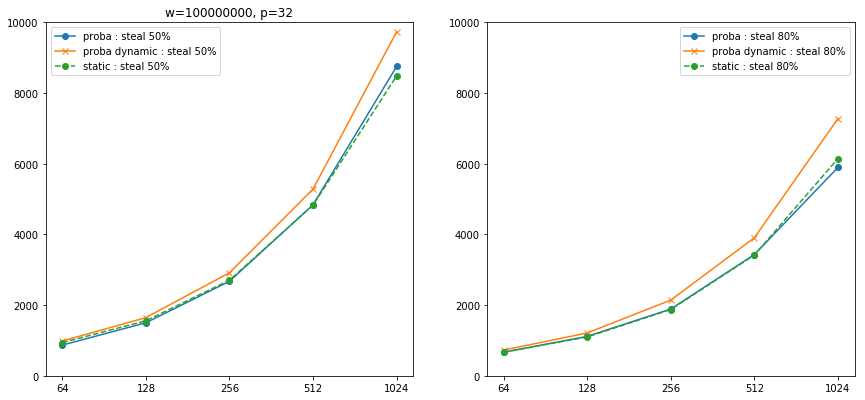

In [41]:
fig = plt.figure()
fig.set_size_inches(14.5, 6.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"


directory_pd = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_50p/"
directory_pd_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_70p/"
directory_pd_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_90p/"

directory_p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_50p/"
directory_p_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_70p/"
directory_p_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_90p/"


w = "100000000"
p = "32"

plt.subplot(121)

plt.ylim(0,10000)
plt.title("w={}, p={}".format(w,p))
filename = directory_p + "vss_proba_"+p+"_"+w
best_proba_50, _ = plot_for_best(filename)

filename = directory_pd + "vss_proba_dynamic_"+p+"_"+w
best_proba_dynamic_50, _ = plot_for_best(filename)

filename = directory + "vss_static_"+p+"_"+w
best_static_50, _ = plot_for_best(filename)

plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_dynamic_50.keys(), best_proba_dynamic_50.values(), 'x-', label="proba dynamic : steal 50%")
plt.plot(best_static_50.keys(), best_static_50.values(), 'o--', label="static : steal 50%")
plt.legend()

plt.subplot(122)
plt.ylim(0,10000)

filename = directory_p_70p + "vss_proba_"+p+"_"+w
best_proba_70, _ = plot_for_best(filename)

filename = directory_pd_70p + "vss_proba_dynamic_"+p+"_"+w
best_proba_dynamic_70, _ = plot_for_best(filename)

filename = directory_70p + "vss_static_"+p+"_"+w
best_static_70, _ = plot_for_best(filename)

plt.plot(best_proba_70.keys(), best_proba_70.values(), 'o-', label="proba : steal 80%")
plt.plot(best_proba_dynamic_70.keys(), best_proba_dynamic_70.values(), 'x-', label="proba dynamic : steal 80%")
plt.plot(best_static_70.keys(), best_static_70.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/proba_05_vs_08_32_100000000.pdf',bbox_inches='tight')


NameError: name 'directory_pd' is not defined

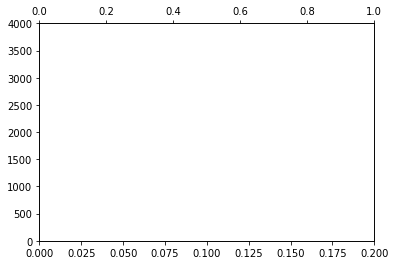

In [13]:
w = "500000000"
p = "64"

fig = plt.figure()
plt.ylim(0,4000)
plt.xlim(0,0.2)
axes1 = fig.add_subplot(111)
axes2 = axes1.twiny()    # share the y-axis


data = load_file(directory_pd + "vss_proba_dynamic_"+p+"_"+w)
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
axes1.plot(overhead.keys(), overhead.values(), "x-", label="pd")


data = load_file(directory_p + "vss_proba_"+p+"_"+w, line=0)
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
axes1.plot(overhead.keys(), overhead.values(), "o-", label="p")

data = load_file(directory_s + "vss_static_"+p+"_"+w, line=0)
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
axes2.plot(overhead.keys(), overhead.values(), "x--", label="s")

axes1.legend()
axes2.legend()

# a faire : 

- Separer les courbes, les decrires,

- afficher les intervals de confiance

- mettre a jour les courbes avec les nouveaux dimulation


## amount of work steal (80% vs 50%)
we plot the overhead according to the latency for best parametre "$rsp$" or "$max\ internal\ steal$" 

In [23]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_32_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_32_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_32_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_32_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

OSError: /home/khatiri/these/projet/ws-simulator/Simulation/static/vss_proba_32_10000000 not found.

<Figure size 1332x756 with 0 Axes>

In [69]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_100000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_100000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_100000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_100000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

OSError: /home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/vss_proba_16_100000000 not found.

<Figure size 1332x756 with 0 Axes>

In [70]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

OSError: /home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/vss_proba_16_10000000 not found.

<Figure size 1332x756 with 0 Axes>

# A faire :

- tourner plus de resultats pour clarifier les choses
- tourner des resultats pour les autres strategies

dict_keys([1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0])


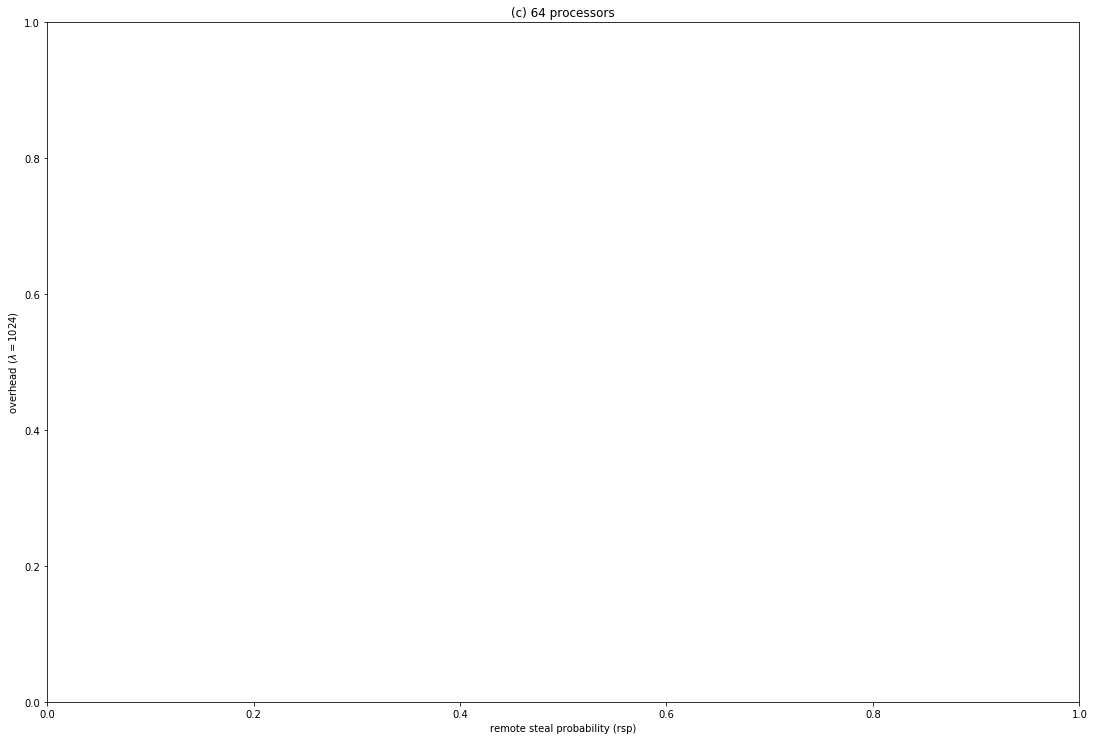

In [16]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)


overhead_ratio_05 = defaultdict(dict)

#plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 0
#for (l,lim) in sorted({(64,3000),(128,6000),(256,10000),(512,20000)}):
for (l, limy, limx) in sorted({(64,0,3000),(128, 0, 6000),(256,0, 10000),(512,0, 20000),(1024,0, 20000)}):

    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
       # plt.subplot(4, 3, position)
        
        #labels
        if l == 512:
            plt.xlabel("remote steal probability (rsp)")
        if l == 64:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        #plt.xlim(0.001, 0.5)
        #plt.ylim(limy, limx)
        
        #plots
        for w1, w2, s in sorted({(10000000,"1.$10^7$", "x--"),(50000000,"5.$10^7$", "o--"), (100000000,"1.$10^8$", "x-"), (500000000,"5.$10^8$", "o-")}):
            data = load_file(directory + "vss_static_"+str(p)+"_"+str(w1))
            #plt.title("l="+str(l)+" p="+str(p)+" w="+str(w1))
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            if(w1== 10000000 and l == 512 and p == 32):
                print(overhead.keys())
            overhead_ratio_05[(w1,p)][l] =  overhead[11]/overhead[minimum]
            #print(overhead[0.05], overhead[minimum], overhead[11]/overhead[minimum])


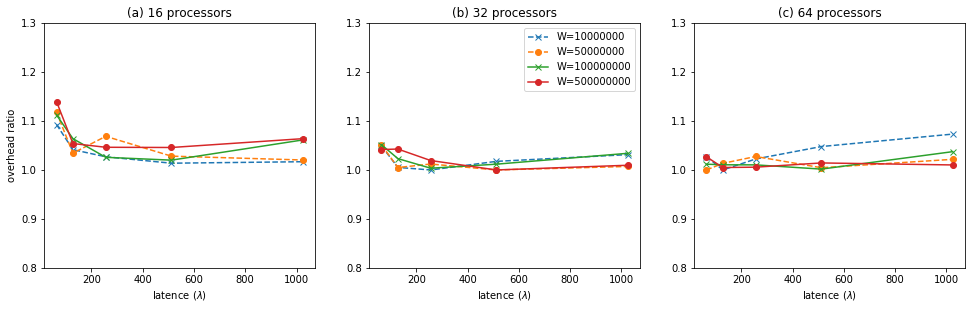

In [18]:
fig = plt.figure()
fig.set_size_inches(16.5, 4.5, forward=True)

#plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 0
#for (l,lim) in sorted({(64,3000),(128,6000),(256,10000),(512,20000)}):
#for (l, limy, limx) in sorted({(64,0,3000),(128, 0, 6000),(256,0, 10000),(512,0, 20000)}):

for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
    #position
    position += 1
    plt.subplot(1, 3, position)
        
    #labels
    plt.xlabel("latence ($\lambda$)")
    plt.title(c+" "+str(p)+" processors")
    if p == 16:
        plt.ylabel("overhead ratio")
        
    #limits
    plt.ylim(0.8, 1.3)
    #plt.ylim(limy, limx)
        
    #plots
    for w1, w2, s in sorted({(10000000,"1.$10^7$", "x--"),(50000000,"5.$10^7$", "o--"), (100000000,"1.$10^8$", "x-"), (500000000,"5.$10^8$", "o-")}):
        #plt.title("l="+str(l)+" p="+str(p)+" w="+str(w1))
        plt.plot(overhead_ratio_05[(w1,p)].keys(), overhead_ratio_05[(w1,p)].values(), s, label="W="+str(w1))

        if p == 32:
            plt.legend()
        plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_ratio_11_according_isa.pdf',bbox_inches='tight')
